# Task Information
## Goal

Submit automated predictions of lesion segmentation boundaries within dermoscopic images.

![Task 1 example segmentation boundaries](https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task1.png)

## Data
### Input Data

The input data consists of dermoscopic lesion images in JPEG format.

***All lesion images are named using the scheme ISIC_<image_id>.jpg, where <image_id> is a 7-digit unique identifier. EXIF tags in the images have been removed; any remaining EXIF tags should not be relied upon to provide accurate metadata.***

The lesion images were acquired with a variety of [dermatoscope types](https://dermoscopedia.org/Principles_of_dermoscopy), from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

### Response Data

The response data consists binary mask images in PNG format, indicating the location of the primary skin lesion within each input lesion image.

***Mask images are named using the scheme ISIC_<image_id>_segmentation.png, where <image_id> matches the corresponding lesion image for the mask.***

***Mask images must have the exact same dimensions as their corresponding lesion image. Mask images are encoded as single-channel (grayscale) 8-bit PNGs (to provide lossless compression), where each pixel is either:***

* 0: representing the background of the image, or areas outside the primary lesion
* 255: representing the foreground of the image, or areas inside the primary lesion

As the primary skin lesion is a single contiguous region, mask images should also contain only a single contiguous foreground region, without any disconnected components or holes. The foreground region may be of any size (including the entire image) and may abut the borders of the image.


### Ground Truth Provenance

Mask image ground truth (provided for training and used internally for scoring validation and test phases) data were generated using several techniques, but all data were reviewed and curated by practicing dermatologists with expertise in dermoscopy.

Ground truth segmentations were generated by either:

fully-automated algorithm, reviewed and accepted by a human expert
a semi-automated flood-fill algorithm, with parameters chosen by a human expert
manual polygon tracing by a human expert

In [1]:
import os, sys, random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
from skimage.io import imread, imshow

### Generate data
The DataGenerator class is used for building generators for training and testing the model.

In [10]:
class DataGenerator(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=8, img_width=128, img_height=128):
        """Initialization"""
        self.ids = ids
        self.path = path
        self.batch_size = batch_size # Number of training samples at one time
        self.img_width = img_width # size of the pics
        self.img_height = img_height
        self.on_epoch_end()
        
    def __load__(self, id_name):
        """load each image from local file path"""
        # file path
        image_path = os.path.join(self.path, "images", id_name) + ".jpg" # train image
        mask_path = os.path.join(self.path, "masks", id_name) + "_segmentation.png" # segmentation image
        
        # Read the original image and the correctly segmented image separately
        # Since out image is in GrayScale form but we need image in 3 channel form
        train_image = imread(image_path) # Load color imgs
        train_image = resize(train_image, (self.img_width, self.img_height), mode='constant', preserve_range=True) # adjust size
        mask = np.zeros((self.img_width, self.img_height, 1), dtype=np.bool) # 128 * 128 * 1
        _mask = imread(mask_path) # cv2.IMREAD_UNCHANGED
        _mask = np.expand_dims(resize(_mask, (img_width, img_height), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, _mask) # Select maximum
        
        # normalize the images in range [0, 1]
        train_image = train_image / 255.0
        mask = mask / 255.0
        
        return train_image, mask
    
    def __getitem__(self, index):
        """Generate one batch of data : Returns i'th batch"""
        # Generate indexes of the batch
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        # Take the batch of directories
        files_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        train_image = []
        mask  = []
        
        # pass each directory name to __load__() method, where we extract both image and masks and perform operations.
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            train_image.append(_img)
            mask.append(_mask)
            
        train_image = np.array(train_image)
        mask  = np.array(mask)
        
        return train_image, mask # Return array
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        pass
    
    def __len__(self):
        """Denotes the number of batches per epoch : Returns number of batches"""
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

### Hyperparameters

In [11]:
# Set some parameters
img_width = 128 # 384
img_height = 128
img_channels = 3
batch_size = 20

path = "./dataset/ISIC2018_Task1-2_Training_Data/" 
train_path = "./dataset/ISIC2018_Task1-2_Training_Data/images" # Training set path


train_ids = []
for imgs in os.walk(train_path): # Traverse directory
       for id in imgs:
              train_ids.append(id)

train_ids = train_ids[2] # Get file name
train_ids = [i.split('.', 1)[0] for i in train_ids] # remove .jpg suffix

validation_data_size = 40 # Validation set size

valid_ids = train_ids[:validation_data_size]
train_ids = train_ids[validation_data_size:] # Data is divided into 2 parts

In [12]:
ids=valid_ids + train_ids
print("No. of images = ", len(ids))

No. of images =  2594


In [13]:
data = DataGenerator(train_ids, path, batch_size=batch_size, img_width=img_width, img_height=img_height) # Read training pictures

x, y = data.__getitem__(0)
print("first image shape: ", x.shape, y.shape)
x1, y1 = data.__getitem__(1)
print("second image shape:", x1.shape, y1.shape)
if x.shape == x1.shape and y.shape == y1.shape:
    print("same!")

first image shape:  (20, 128, 128, 3) (20, 128, 128, 1)
second image shape: (20, 128, 128, 3) (20, 128, 128, 1)
same!


#### alternative way to get x_train and y_train, compare to above, just trial

In [ ]:
from tqdm import tqdm

image_ids = next(os.walk(train_path))[2]

X = np.zeros((len(image_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y = np.zeros((len(image_ids), img_height, img_width, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = path
    img = imread(path + '/images/' + id_ )
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    mask_ = imread(path + '/masks/' +  id_ )
    mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X

y_train=Y

### Verify whether the image is successfully read

random number:  10


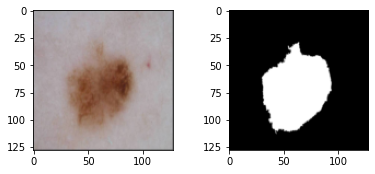

In [23]:
n = random.randint(0, len(x) - 1) # Random number within the number of pictures
print("random number: ", n)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust the page layout
ax = fig.add_subplot(1, 2, 1) # the first plot
ax.imshow(x[n])
ax = fig.add_subplot(1, 2, 2) # the sec plot
ax.imshow(np.reshape(y[n], (img_width, img_height)), cmap="gray")

#### The UNet is a ‘U’ shaped network which consists of three parts: 

1. The Contracting/Downsampling Path
2. Bottleneck
3. The Expanding/Upsampling Path

### Downsampling Path
It consists of two 3×3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

### Upsampling Path
Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”), a concatenation with the correspondingly feature map from the downsampling path, and two 3×3 convolutions, each followed by a ReLU.

### Skip Connection
The skip connections from the downsampling path are concatenated with the feature map during upsampling path. These skip connections provide local information to global information while upsampling.

### Final Layer
At the final layer a 1×1 convolution is used to map each feature vector to the desired number of classes.

### Advantages
- The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.
- No Dense layer is used, so image sizes can be used.

In [15]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.layers import UpSampling2D, Concatenate

In [16]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# imput image tile
def Downsampling(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    return c, p

def Upsampling(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottom_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [17]:
# Next we build the complete UNet architecture in the UNet function. 
# This function uses the down_block, bottleneck and up_block to build the UNet.
def UNet():
    filter_size = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_width, img_height, 3))
    
    p0 = inputs
    d1, p1 = Downsampling(p0, filter_size[0]) # 128 -> 64
    d2, p2 = Downsampling(p1, filter_size[1]) # 64 -> 32
    d3, p3 = Downsampling(p2, filter_size[2]) # 32 -> 16
    d4, p4 = Downsampling(p3, filter_size[3]) # 16 -> 8
    
    bb = bottom_block(p4, filter_size[4])
    
    u1 = Upsampling(bb, d4, filter_size[3]) # 8 -> 16
    u2 = Upsampling(u1, d3, filter_size[2]) # 16 -> 32
    u3 = Upsampling(u2, d2, filter_size[1]) # 32 -> 64
    u4 = Upsampling(u3, d1, filter_size[0]) # 64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

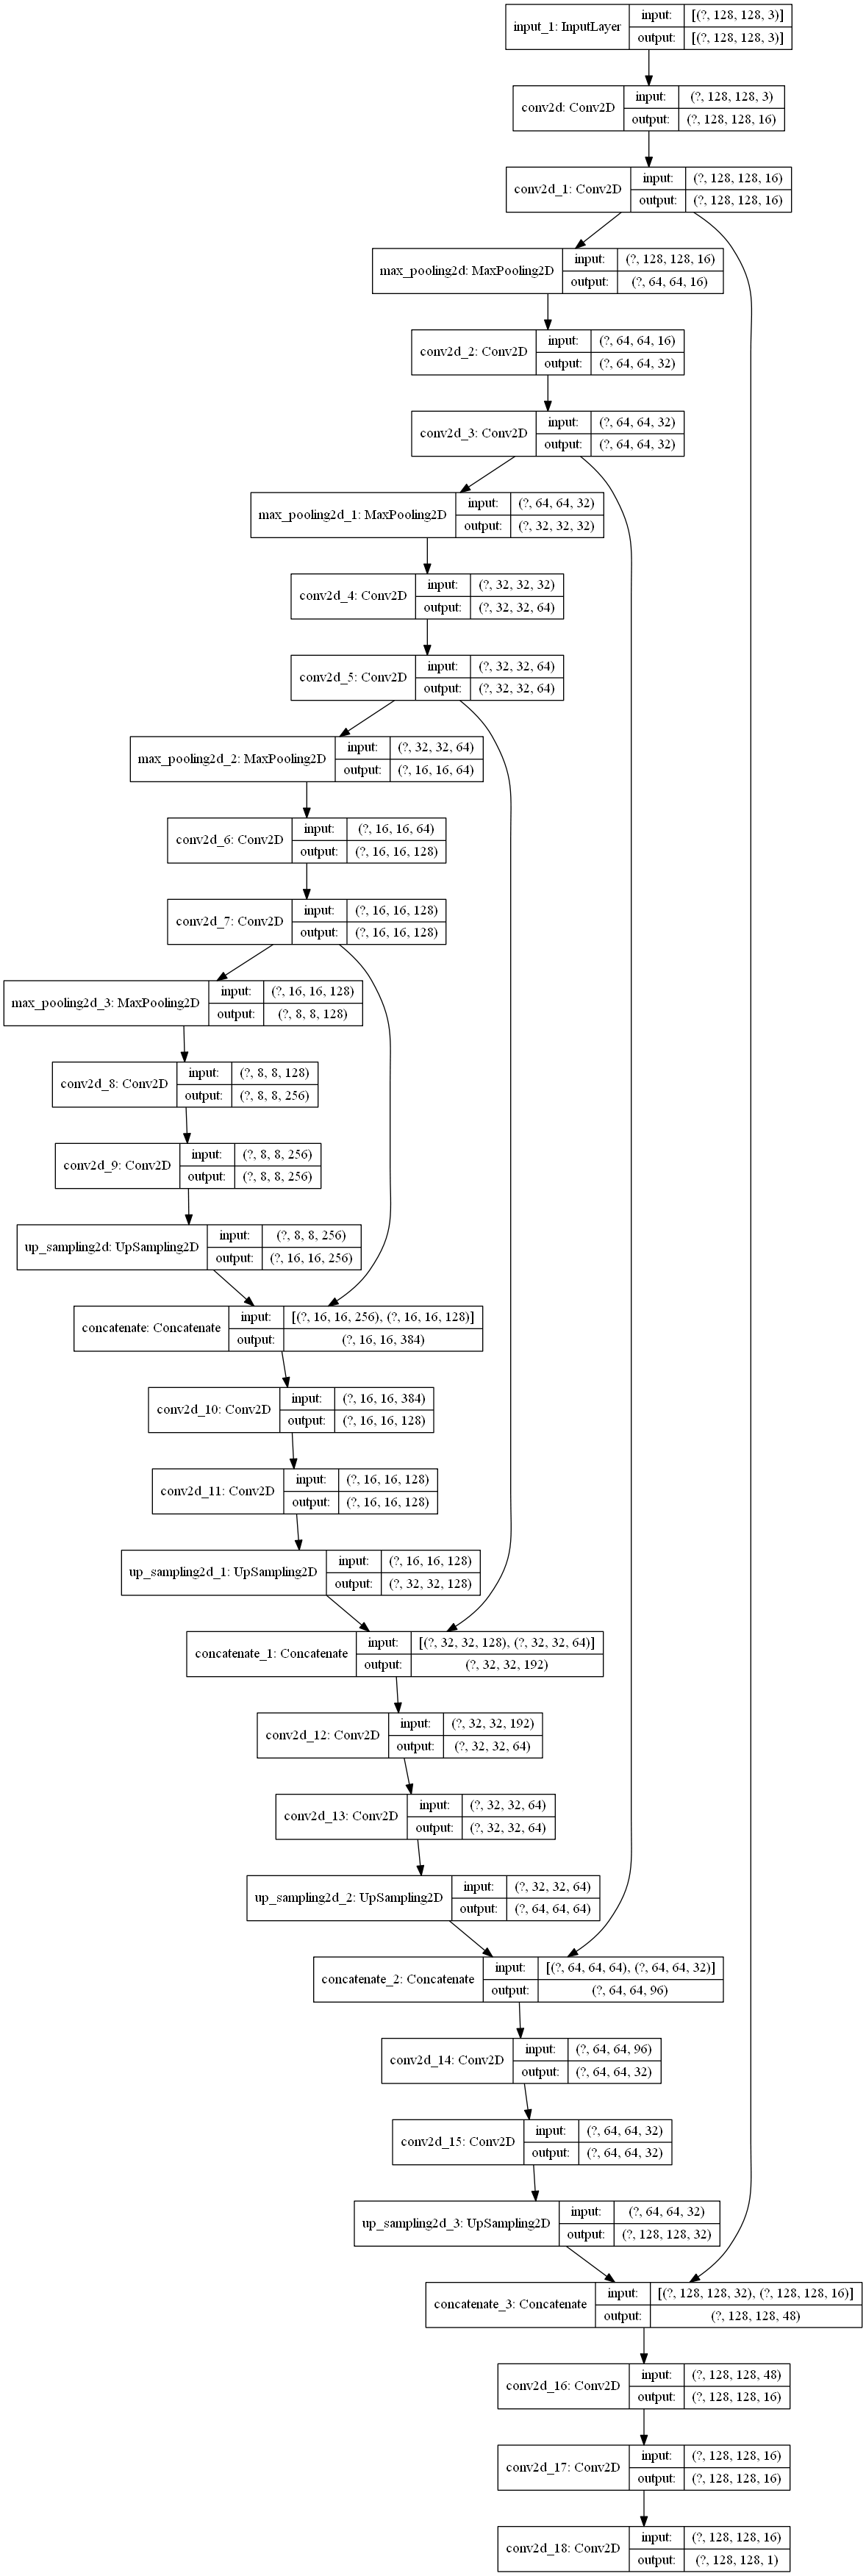

In [18]:
# After we finished building the UNet model, we compile this model. 
# For this experiment, we uses Adam optimizer, binary crossentropy as loss function 
# and accuracy as the metric to measure the performance.
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])#优化器，损失函数，评估标准
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### Training
Here we create the two data generator, one for the training using the training data and other using the validation data. After that we start training the model.

In [19]:
train_gen = DataGenerator(train_ids, path)
valid_gen = DataGenerator(valid_ids, path, 3, 128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# Train the model by batch
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = 10)
model.save("Basic_U_Net_Model.h5") # Save model

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
127/127 [==============================] - 340s 3s/step - loss: 0.5715 - acc: 0.7576 - val_loss: 0.4822 - val_acc: 0.7481
Epoch 2/10
127/127 [==============================] - 231s 2s/step - loss: 0.4199 - acc: 0.7845 - val_loss: 0.5652 - val_acc: 0.7481
Epoch 3/10
127/127 [==============================] - 225s 2s/step - loss: 0.4131 - acc: 0.7866 - val_loss: 0.4091 - val_acc: 0.7481
Epoch 4/10
127/127 [==============================] - 261s 2s/step - loss: 0.4285 - acc: 0.7722 - val_loss: 0.5767 - val_acc: 0.7481
Epoch 5/10
127/127 [==============================] - 235s 2s/step - loss: 0.4198 - acc: 0.7614 - val_loss: 0.3547 - val_acc: 0.8216
Epoch 6/10
127/127 [==============================] - 231s 2s/step - loss: 0.3818 - acc: 0.7725 - val_loss: 0.2972 - val_acc: 0.8542
Epoch 7/10
127/127 [==============================] - 177s 1s/step - loss: 0.4224 - acc: 0.7671 - val_loss: 0.3426 - val_acc: 

In [20]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Basic_U_Net_Model.h5")

#### alternative way, compare to above, just trial

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1)
]

In [39]:
history = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)

# history = model.fit(x, y, batch_size=32, epochs=10, callbacks = callbacks, steps_per_epoch=train_steps, 
#                     validation_steps=valid_steps, shuffle=True, validation_data=img_validate)

Epoch 1/20
2/2 [==============================] - 1s 345ms/step - loss: 0.6290 - acc: 0.6358 - val_loss: 0.6996 - val_acc: 0.3857
Epoch 2/20
2/2 [==============================] - 0s 133ms/step - loss: 0.6277 - acc: 0.6358 - val_loss: 0.7147 - val_acc: 0.3857
Epoch 3/20
2/2 [==============================] - 0s 131ms/step - loss: 0.6274 - acc: 0.6358 - val_loss: 0.7187 - val_acc: 0.3857
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.6358
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2/2 [==============================] - 0s 134ms/step - loss: 0.6213 - acc: 0.6358 - val_loss: 0.7203 - val_acc: 0.3857
Epoch 5/20
2/2 [==============================] - 0s 141ms/step - loss: 0.6117 - acc: 0.6358 - val_loss: 0.7210 - val_acc: 0.3857
Epoch 6/20
2/2 [==============================] - 0s 132ms/step - loss: 0.6103 - acc: 0.6358 - val_loss: 0.7226 - val_acc: 0.3857
Epoch 7/20
2/2 [==============================] - ETA: 0s - los

### Make predictions
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Generates output predictions for the input samples.\
note: Remember to load the best-saved model if you've used early stopping.
***return***: Numpy array(s) of predictions.

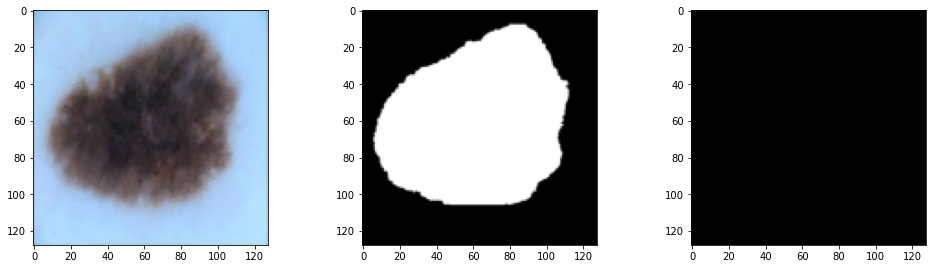

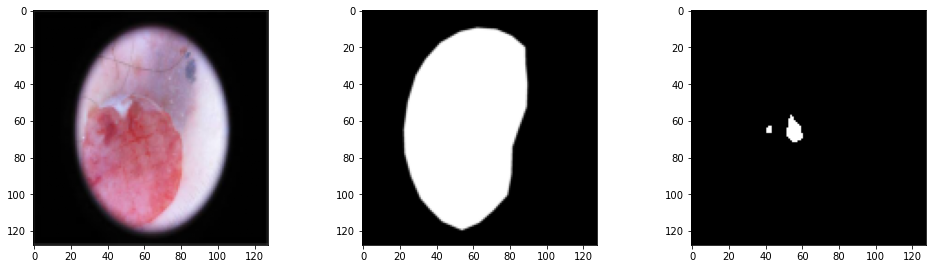

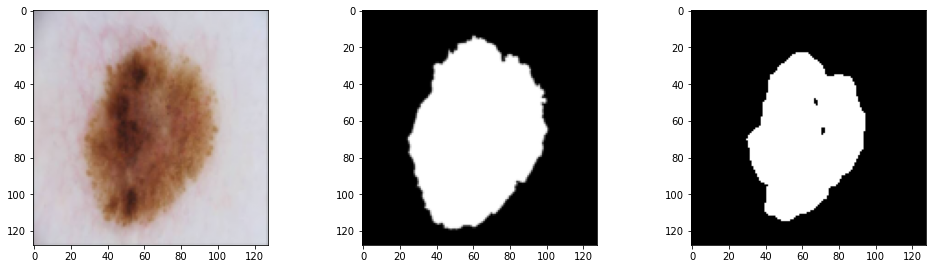

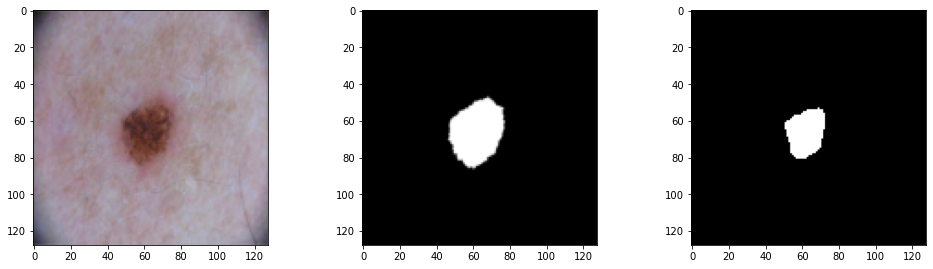

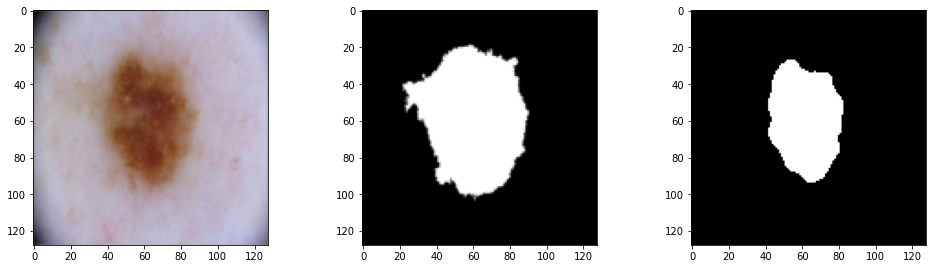

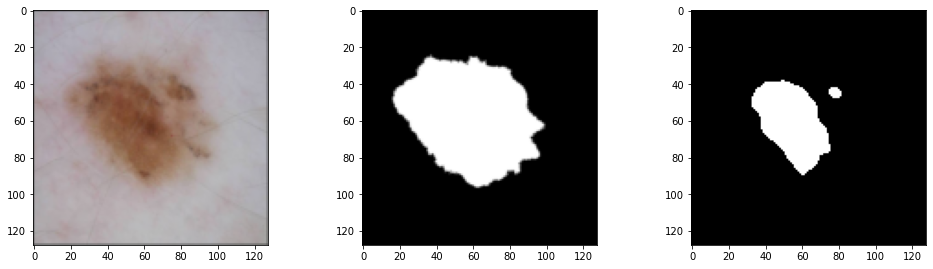

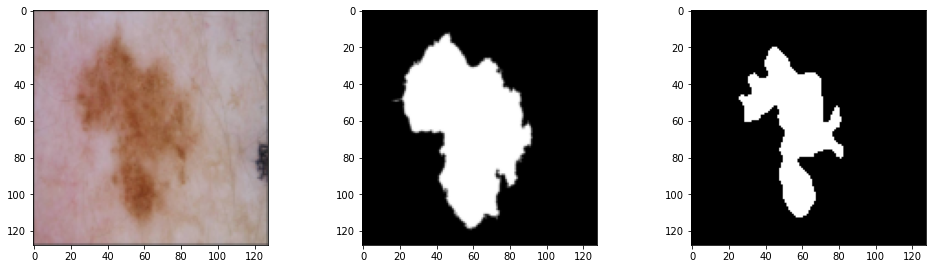

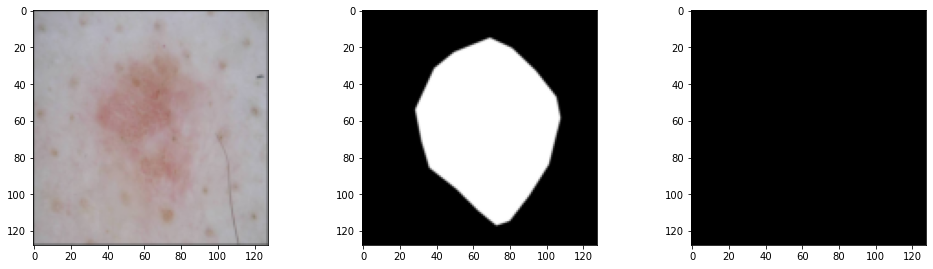

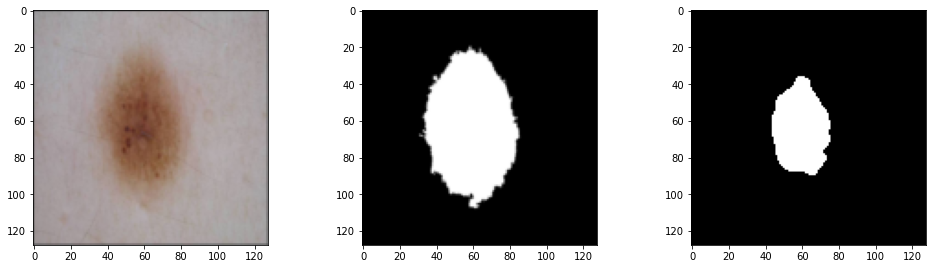

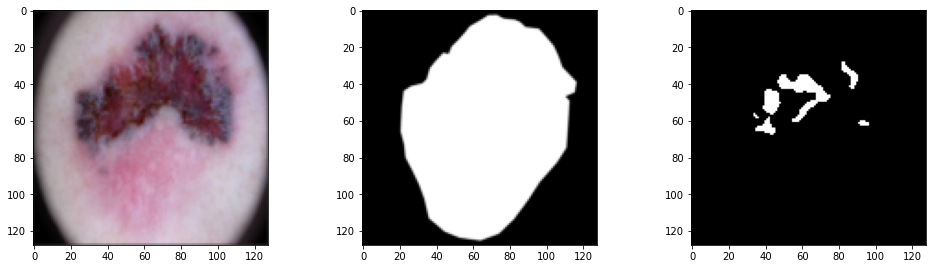

In [21]:
for i in range(0,10):
    x_train, y_train = valid_gen.__getitem__(i)
    preds_train = model.predict(x_train)
    
    preds_train = preds_train > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    # 1 origin image
    ax.imshow(x_train[0])
    ax = fig.add_subplot(1, 3, 2)
    # 2 origin mask
    ax.imshow(np.reshape(y_train[0]*255, (img_width, img_height)), cmap="gray")
    # 3 predicted mask
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(preds_train[0]*255, (img_width, img_height)), cmap="gray")

### save result image for readme

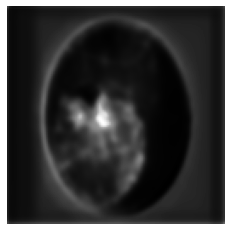

In [25]:
x_train, y_train = valid_gen.__getitem__(0)
preds_train = model.predict(x_train)
plt.imshow(x_train[0])
plt.axis('off')
plt.savefig('resources/x_train_11.png',bbox_inches='tight')
plt.imshow(np.reshape(y_train[0]*255, (img_width, img_height)), cmap="gray")
plt.axis('off')
plt.savefig('resources/y_train_11.png',bbox_inches='tight')
plt.imshow(np.reshape(preds_train[0]*255, (img_width, img_height)), cmap="gray")
plt.axis('off')
plt.savefig('resources/preds_train_11.png',bbox_inches='tight')

x_train, y_train = valid_gen.__getitem__(1)
preds_train = model.predict(x_train)
plt.imshow(x_train[0])
plt.axis('off')
plt.savefig('resources/x_train_12.png',bbox_inches='tight')
plt.imshow(np.reshape(y_train[0]*255, (img_width, img_height)), cmap="gray")
plt.axis('off')
plt.savefig('resources/y_train_12.png',bbox_inches='tight')
plt.imshow(np.reshape(preds_train[0]*255, (img_width, img_height)), cmap="gray")
plt.axis('off')
plt.savefig('resources/preds_train_12.png',bbox_inches='tight')

## Evaluation

### Goal Metric

Predicted responses are scored using a threshold [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) metric.

To compute this metric:

* For each image, a pixel-wise comparison of each predicted segmentation with the corresponding ground truth segmentation is made using the Jaccard index.
* The final score for each image is computed as a threshold of the Jaccard according to the following:
  * score = 0, if the Jaccard index is less than 0.65
  * score = the Jaccard index value, otherwise
* The mean of all per-image scores is taken as the final metric value for the entire dataset

### Other Metrics
For scientific completeness, predicted responses will also have the following metrics computed on a pixel-wise basis (comparing prediction vs. ground truth) for each image:

* sensitivity\
(specificity)\
(accuracy)\
(raw Jaccard index)\
Dice coefficient

NOTE:
The Dice coefficient is defined as:\
Dice = 2 * TP / ( 2 * TP + FP + FN )\
The Jaccard index is defined as:\
Jaccard = TP / ( TP + FP + FN )

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

print(compute_jaccard(y_train, preds_train))

(0.23626984622064495, 0.0)


In [27]:
# idea about how to calculate dice_coef
import keras.backend as K
def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred)
    return K.mean((2. * intersection + 1) / (union + 1))

def compute_dice(y_true, y_pred):

    mean_dice = 0.
    thresholded_dice = 0.

    for im_index in range(y_pred.shape[0]):

        current_dice = dice_coef(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_dice += current_dice
        thresholded_dice += 0 if current_dice < 0.65 else current_dice

    mean_dice = mean_dice/y_pred.shape[0]
    thresholded_dice = thresholded_dice/y_pred.shape[0]

    return mean_dice, thresholded_dice

print(compute_dice(y_train, preds_train))

InvalidArgumentError: Invalid reduction dimension (3 for input with 3 dimension(s) [Op:Sum]

# References

Data was extracted from the “ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection” grand challenge datasets [1][2].

[1] Noel C. F. Codella, David Gutman, M. Emre Celebi, Brian Helba, Michael A. Marchetti, Stephen W. Dusza, Aadi Kalloo, Konstantinos Liopyris, Nabin Mishra, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)”, 2017; arXiv:1710.05006.

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).